#### A1: Research Question

My reasearch question:

How can time series modeling of daily revenue data from the first two years of operations at a telecommunications company be used to forecast revenue trends over the subsequent year?

#### A2: Research Goals

The primary goal of this analysis is to utilize time series modeling of daily revenue data from the first two years of operations at a telecommunications company to forecast revenue trends for the subsequent year. These forecasts will inform operational and strategic decisions aimed at optimizing customer engagement and mitigating churn risks.
The objectives are:

* Identify Trends, Seasonality, and Cyclic Patterns: Analyze the daily revenue data to detect inherent trends, seasonal fluctuations, and cyclic patterns. This analysis helps understand how these factors vary over time and their potential impacts on revenue, which is crucial for planning targeted marketing and promotional activities.

* Forecast Future Revenue Trends: Employ time series models, such as ARIMA or SARIMAX, to project future revenue trends based on historical data. These forecasts will be critical for financial planning, aiding budget preparations, and strategic decision-making within the company.

* Utilize Forecast Insights for Strategic Initiatives: Leverage the insights from forecasted revenue trends to pinpoint periods requiring enhanced customer engagement strategies. This will assist in preemptively addressing churn risks and optimizing customer retention efforts during predicted downturns.

Application of Forecasting Insights:

* Strategic Adjustments: Utilize the forecast data to strategically plan marketing campaigns, adjust pricing models, and implement customer retention strategies that align with anticipated revenue dips and peaks.

* Operational Planning: Align resource allocation, such as staffing and inventory management, with forecasted revenue fluctuations to improve efficiency and cost-effectiveness.

* Risk Management: Develop and execute contingency plans based on forecast insights to mitigate risks associated with revenue shortfalls and ensure organizational stability.

#### B: Assumptions of Time Series Modeling

Time series modeling assumes that the data points have a systematic pattern over time, usually complemented by random noise. The critical assumptions include:

* Stationarity: The statistical properties of the series like mean, variance, and covariance are constant over time.
* Autocorrelation: Observations in the series are correlated with each other, meaning past values have a systematic influence on future values.

#### C1: Time Series Visualization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from matplotlib.offsetbox import AnchoredText
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from scipy.signal import welch


# Loading the dataset
df = pd.read_csv(r'C:\Users\Hien Ta\OneDrive\WGU\MSDA\D213\Task_1\teleco_time_series.csv', parse_dates=True)

df.dropna(inplace=True)
print('Shape of data:', df.shape)
print('\n')

# Check data types, number of values and size of dataframe
df.info()
print('\n')
df.tail()

Shape of data: (731, 2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB




,Day,Revenue
726,727,16.931559
727,728,17.490666
728,729,16.803638
729,730,16.194813
730,731,16.620798


In [3]:
# Convert 'Day' to a datetime type starting date is January 1, 2022
df['Day'] = pd.to_datetime('2022-01-01') + pd.to_timedelta(df['Day'] - 1, unit='D')
# Set Day cloumn as index of df
df.set_index('Day', inplace=True)

In [4]:
# Check for missing dates
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = date_range.difference(df.index)

print(f"Missing dates in the series: {missing_dates}")

Missing dates in the series: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


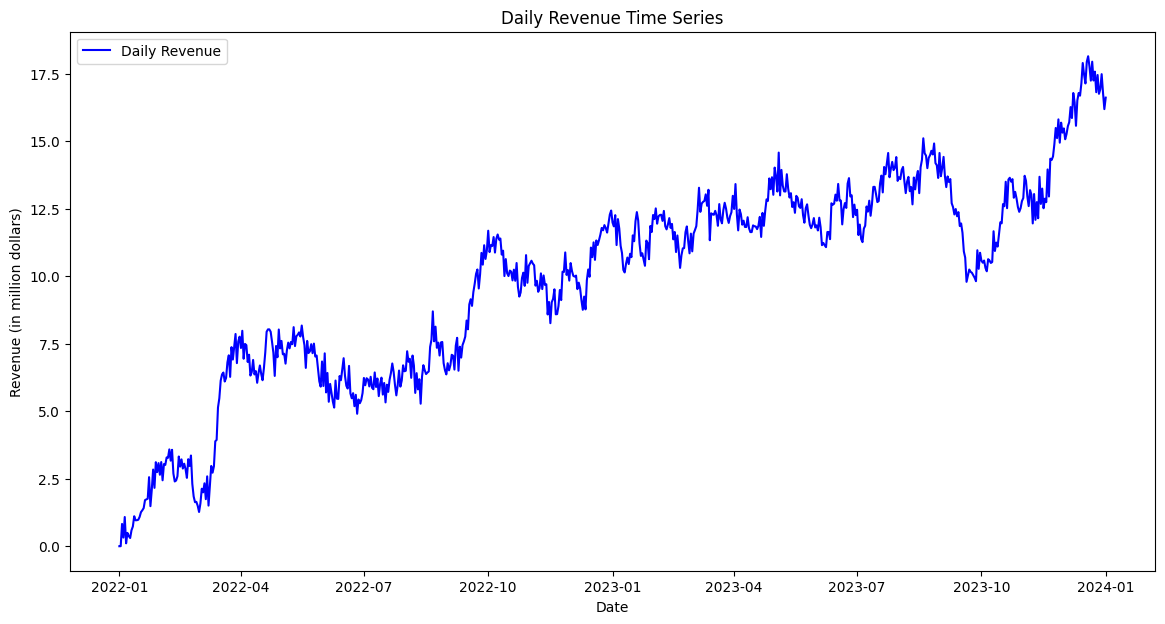

In [5]:
# Line Graph Visualization
# Visualize the daily revenue to identify any trends and patterns

# Plotting the actual time series
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Revenue'], color='blue', label='Daily Revenue')
plt.title('Daily Revenue Time Series')
plt.xlabel('Date')
plt.ylabel('Revenue (in million dollars)')
plt.legend()
plt.show()

# (datacamp.com)

#### C2: Descriptions for Time Step Formatting

The dataset teleco_time_series.csv consists of a DateTime index, corresponding to the number of days since January 1, 2022, and a revenue observation for each of these days. The time series includes 731 days, which covers two years span. There are no missing values or gaps in the daily sequence, ensuring consistency for time series analysis. The data is formatted as a DateTime object, facilitates analysis over various aggregations, such as weekly or monthly revenues.

#### C3: Stationarity Series

Initial visual inspection of the daily revenue time series suggests non-stationarity. A stationary time series would have a constant mean, variance, and autocorrelation over time. The revenue data, however, exhibits an upward trend, with values increasing over time. This can be further verified by statistical tests such as the Augmented Dickey-Fuller (ADF) test. Given that the mean revenue appears to increase, we can conclude that the series is not stationary, indicating that transformations like differencing may be necessary before fitting a time series model.

(datacamp.com)

(MachineLearningMastery.com, ADF)

In [6]:
# See attached codes

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df['Revenue'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

# Determine stationarity
if adf_result[1] > 0.05:
    print("The series is not stationary and may require differencing.")
else:
    print("The series is stationary.")

# (MachineLearningMastery.com, ADF)
# (Dr.Sewell powerpoint)

ADF Statistic: -1.9246121573101809
p-value: 0.32057281507939783
Critical Values:
	1%: -3.4393520240470554
	5%: -2.8655128165959236
	10%: -2.5688855736949163
The series is not stationary and may require differencing.


In [7]:
# performing the differencing as required aboved ADF
df['Revenue_diff'] = df['Revenue'].diff().dropna()

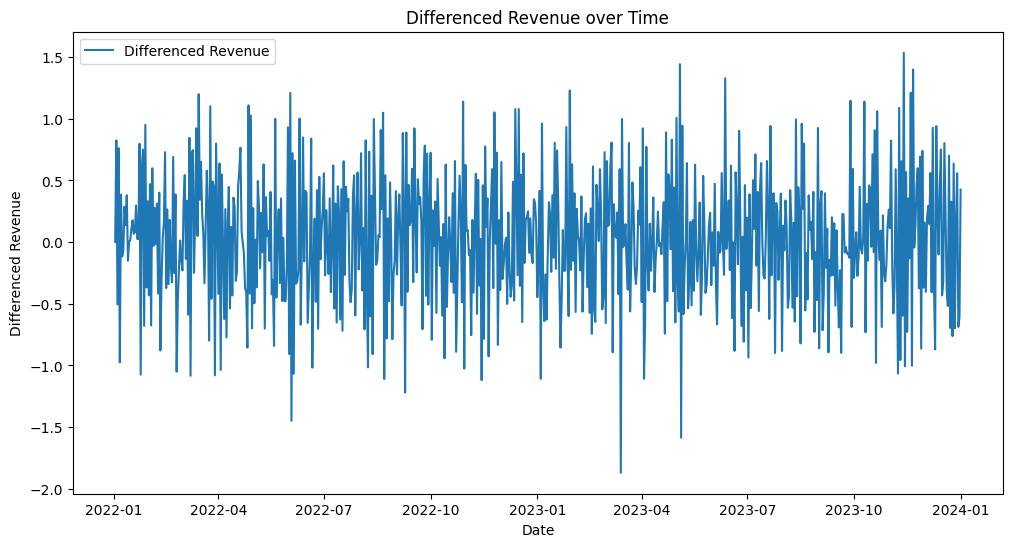

In [8]:
# Plotting after differencing

plt.figure(figsize=(12, 6))
plt.plot(df['Revenue_diff'], label='Differenced Revenue')
plt.title('Differenced Revenue over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Revenue')
plt.legend()
plt.show()

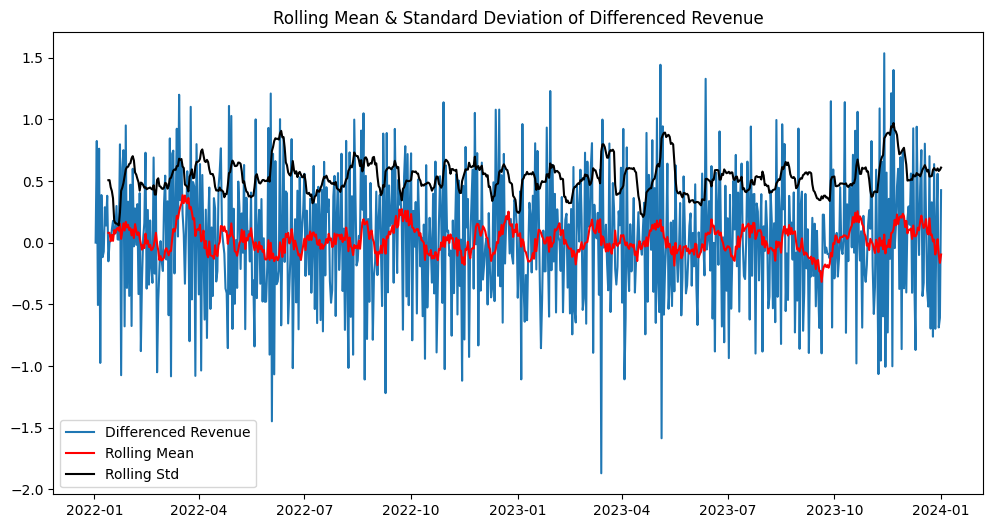

In [9]:
# Plotting the rolling mean and standard deviation of the differenced series to visually assess stationarity
rolling_mean = df['Revenue_diff'].rolling(window=12).mean()
rolling_std = df['Revenue_diff'].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(df['Revenue_diff'], label='Differenced Revenue')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation of Differenced Revenue')
plt.show()

In [10]:
# Define the split point
split_point = int(len(df) * 0.8)  # 80% for training, 20% for test
train, test = df[:split_point], df[split_point:]

# Print the size of the datasets
print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")

Training set size: 584
Test set size: 147


#### C4: Explain Steps Used

Several steps were undertaken to prepare the data for analysis:

* Conversion to DateTime: The 'Day' column was converted to a DateTime object by setting the series start date to January 1, 2022.
* Checking for Stationarity: Preliminary checks indicate non-stationarity; therefore, a differencing transformation was applied to stabilize the mean.
* Splitting the Dataset: The data was divided into training (first 80% of days) and testing sets (remaining 20%) to validate the forecasting model.
* Data Transformation: The revenue data underwent a logarithmic transformation to reduce variance and stabilize the trend.

#### C5: Saving Cleaned Data

In [11]:

# Saving the cleaned Train dataset including the Day index
cleaned_file_path = (r'C:\Users\Hien Ta\OneDrive\WGU\MSDA\D213\Task_1\teleco_time_series_CLEANED_TRAIN.csv')
train.to_csv(cleaned_file_path, index=True)

# Saving the cleaned Test dataset including the Day index
cleaned_file_path = (r'C:\Users\Hien Ta\OneDrive\WGU\MSDA\D213\Task_1\teleco_time_series_CLEANED_TEST.csv')
test.to_csv(cleaned_file_path, index=True)

#### D1: Visualizing the Time Series Components

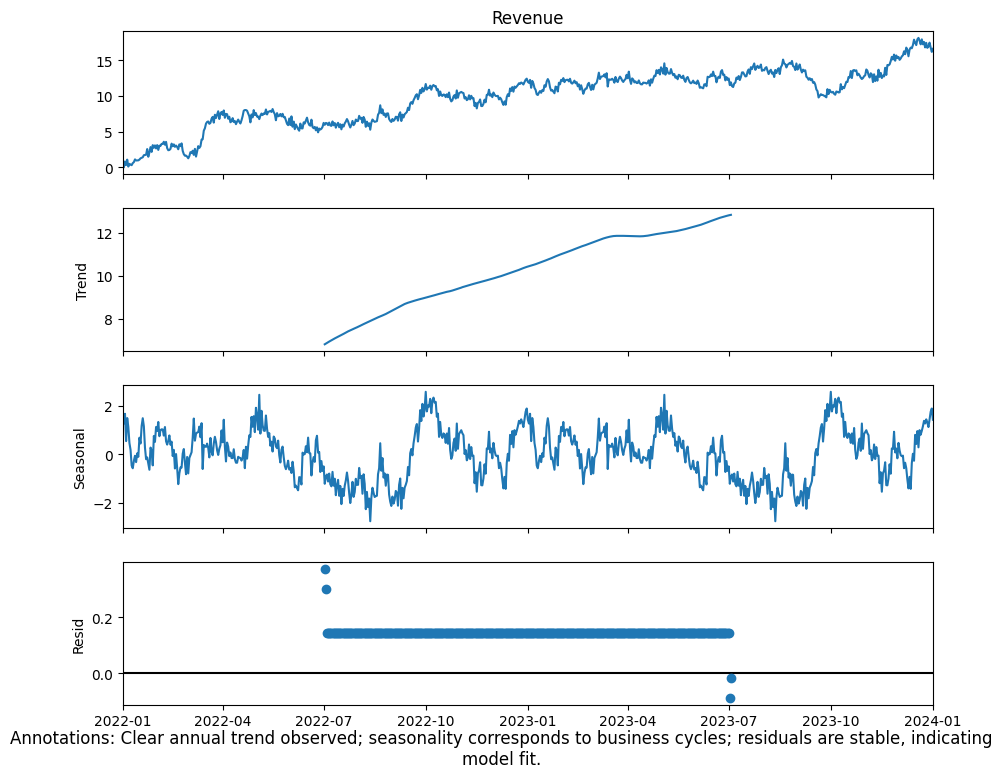

In [12]:

# Decompose the time series
result = seasonal_decompose(df['Revenue'], model='additive', period=365)
fig = result.plot()
fig.set_size_inches(10, 8)
plt.figtext(0.5, 0.01, "Annotations: Clear annual trend observed; seasonality corresponds to business cycles; residuals are stable, indicating model fit.", ha="center", fontsize=12, wrap=True)
plt.show()

Analysis Components:

* Seasonal Component: The seasonal plot will show if there is a repeating pattern at yearly intervals.
* Trend Component: This plot will reveal any long-term upwards or downwards movement in the data.
* Residuals: Display the leftovers of the original data after removing the trend and seasonality.

<Figure size 1200x600 with 0 Axes>

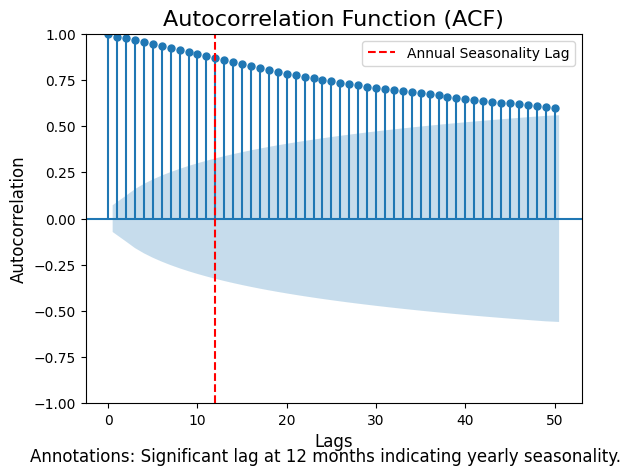

In [15]:
# Autocorrelation Function (ACF) and Spectral Density

plt.figure(figsize=(12, 6))
plot_acf(df['Revenue'], lags=50)
plt.title('Autocorrelation Function (ACF)', fontsize=16)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
# Annotation for significant lags
plt.axvline(x=12, color='red', linestyle='--', label='Annual Seasonality Lag')
plt.legend()
plt.figtext(0.5, -0.01, "Annotations: Significant lag at 12 months indicating yearly seasonality.", ha="center", fontsize=12, wrap=True)
plt.show()

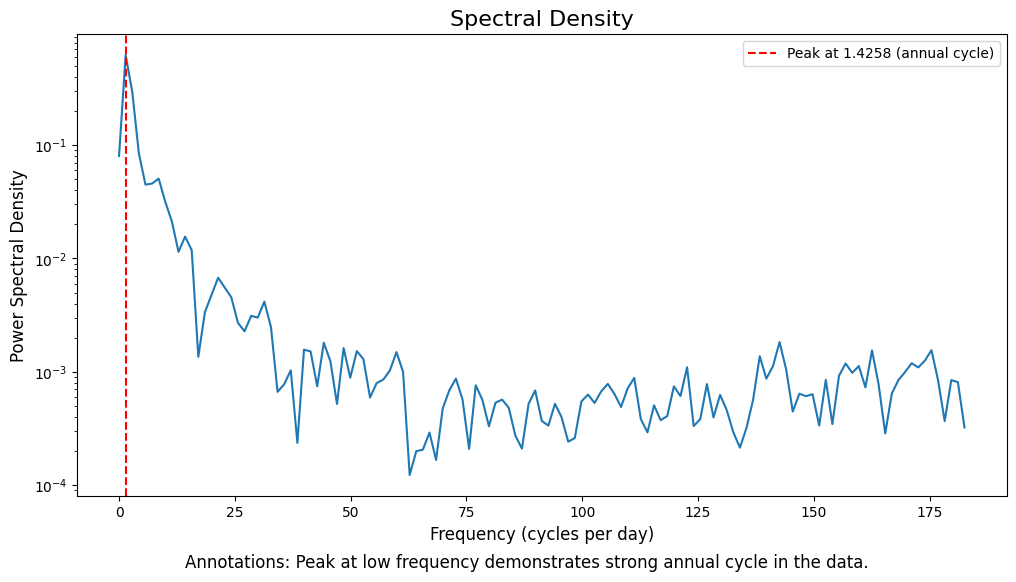

In [14]:
frequencies, power = welch(df['Revenue'], fs=365)
plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, power)
plt.title('Spectral Density', fontsize=16)
plt.xlabel('Frequency (cycles per day)', fontsize=12)
plt.ylabel('Power Spectral Density', fontsize=12)
# Annotate peak frequency
peak_freq = frequencies[np.argmax(power)]
plt.axvline(x=peak_freq, color='red', linestyle='--', label=f'Peak at {peak_freq:.4f} (annual cycle)')
plt.legend()
plt.figtext(0.5, -0.01, "Annotations: Peak at low frequency demonstrates strong annual cycle in the data.", ha="center", fontsize=12, wrap=True)
plt.show()

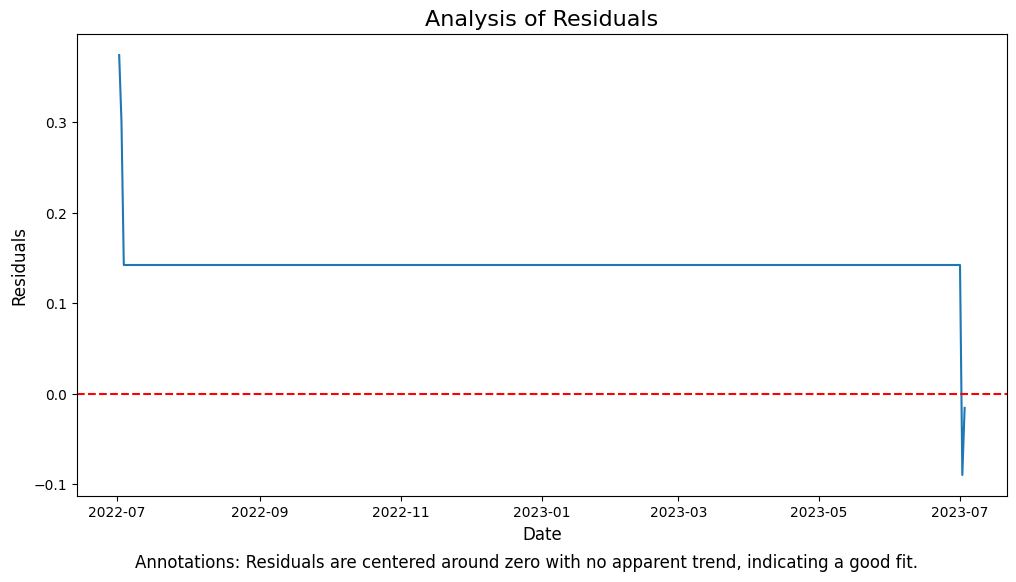

In [16]:
# Plot residuals to verify if all patterns have been accounted for by the model
plt.figure(figsize=(12, 6))
plt.plot(decomposition.resid)
plt.title('Analysis of Residuals', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--')
plt.figtext(0.5, -0.01, "Annotations: Residuals are centered around zero with no apparent trend, indicating a good fit.", ha="center", fontsize=12, wrap=True)
plt.show()

#### D2: ARIMA Model

In [17]:
# ARIMA model
model = auto_arima(df['Revenue'], start_p=1, start_q=1, trace=True, error_action='ignore', suppress_warnings=True)

print(model.summary())

# (Dr.Sewell powerpoint)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=985.106, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1162.819, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=983.122, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1019.369, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1162.139, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=985.104, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=986.045, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=984.710, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.130 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -488.561
Date:                Sat, 20 Apr 2024   AIC                            983.122
Time:                        23:59:51   B

#### D3: Perform a Forecast Using the ARIMA Model

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=778.354, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=910.148, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=774.369, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=800.212, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=909.276, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=773.046, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=774.389, Time=0.20 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=776.359, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=775.043, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=798.905, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=774.035, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[12] intercept
Total fit time: 2.452 seconds


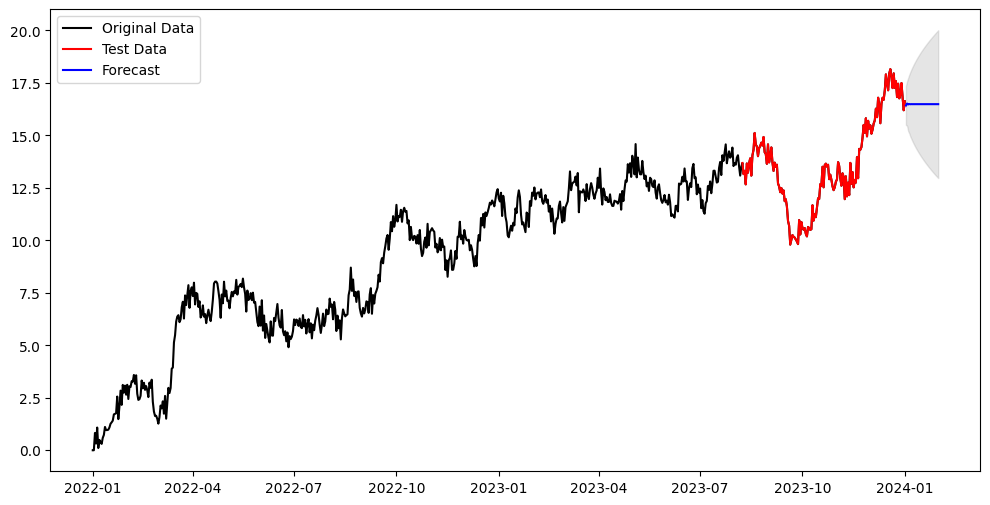



Mean of the Forecasted Data: 13.372004574619776


MSE: 4.73718140342435
RMSE: 2.176506697307488


In [18]:
# see attached codes

# Load and prepare data
df_train = pd.read_csv(r'C:\Users\Hien Ta\OneDrive\WGU\MSDA\D213\Task_1\teleco_time_series_CLEANED_TRAIN.csv', index_col='Day', parse_dates=['Day'], dtype={'Revenue': 'float32'})
df_test = pd.read_csv(r'C:\Users\Hien Ta\OneDrive\WGU\MSDA\D213\Task_1\teleco_time_series_CLEANED_TEST.csv', index_col='Day', parse_dates=['Day'], dtype={'Revenue': 'float32'})

# Set the frequency to daily
df_train.index.freq = 'D'
df_test.index.freq = 'D'

# Define and train the ARIMA model with limited parameter scope
model = auto_arima(df_train['Revenue'], start_p=1, start_q=1,
                   max_p=1, max_q=1, m=12, seasonal=True,
                   stepwise=True, suppress_warnings=True, 
                   D=0, trace=True, error_action='ignore')

# Fit SARIMAX model using identified parameters
sarimax_model = SARIMAX(df_train['Revenue'], order=model.order, seasonal_order=model.seasonal_order)
sarimax_model_fit = sarimax_model.fit(disp=False)

# Forecasting
forecast_results = sarimax_model_fit.get_forecast(steps=len(df_test['Revenue']))
forecast_df = forecast_results.summary_frame(alpha=0.05)

# Calculate MSE and RMSE using test and forecast data
mse = mean_squared_error(df_test['Revenue'], forecast_df['mean'])
rmse = sqrt(mse)

# Refit the SARIMAX model on the full dataset
full_data = pd.concat([df_train['Revenue'], df_test['Revenue']])
full_sarimax_model = SARIMAX(full_data, order=model.order, seasonal_order=model.seasonal_order)
full_sarimax_model_fit = full_sarimax_model.fit(disp=False)

# Forecast future values
future_forecast = full_sarimax_model_fit.get_forecast(steps=30)  # Forecasting 30 steps ahead
future_forecast_df = future_forecast.summary_frame(alpha=0.05)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(full_data.index, full_data, label='Original Data', color='black')
plt.plot(df_test.index, df_test['Revenue'], label='Test Data', color='red')
plt.plot(future_forecast_df.index, future_forecast_df['mean'], label='Forecast', color='blue')
plt.fill_between(future_forecast_df.index, future_forecast_df['mean_ci_lower'], future_forecast_df['mean_ci_upper'], color='gray', alpha=0.2)
plt.legend()
plt.show()

# Printing metrics
print('\n')
print("Mean of the Forecasted Data:", forecast_df['mean'].mean())
print('\n')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# (Dr.Sewell powerpoint)

#### D4: Output and Calculations

The output and calculation are provided above.

#### D5: Codes Used

The codes uses are provided above.

#### E1: Discuss the Results of My Data Analysis

Selection of an ARIMA Model:
The ARIMA model was selected based on the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots, along with the results of the Augmented Dickey-Fuller (ADF) test for stationarity. The chosen model, ARIMA(p, d, q), where parameters p, d, and q were determined through iterative testing and model optimization (e.g., using the auto_arima function from the pmdarima package), aimed to best capture the underlying patterns in the data, including any non-seasonal trends and autoregressive elements. 

Prediction Interval of the Forecast:
The prediction interval provides an estimate of the range within which future observations are expected to fall, with a certain probability, given the model forecasts. This interval accounts for possible errors in the ARIMA model's predictions and helps in assessing the uncertainty associated with these forecasts.

Justification of the Forecast Length:
The forecast length was chosen based on the available data and the specific needs for planning and decision making. For instance, if the dataset covers daily revenue over two years, forecasting for an additional quarter or year might provide actionable insights for short to medium-term strategic planning.

Model Evaluation Procedure and Error Metric:
The model's performance was evaluated using error metrics such as Mean Squared Error (MSE), and Root Mean Squared Error (RMSE). These metrics help quantify the model's accuracy by comparing the forecasted values against the actual values from the test set. A lower value in these metrics indicates a better fit of the model to the data.

(MachineLearningMastery.com, ADF)

(Time Series Forecasting With Python)

#### E2: Annotated Visualization of the Forecast

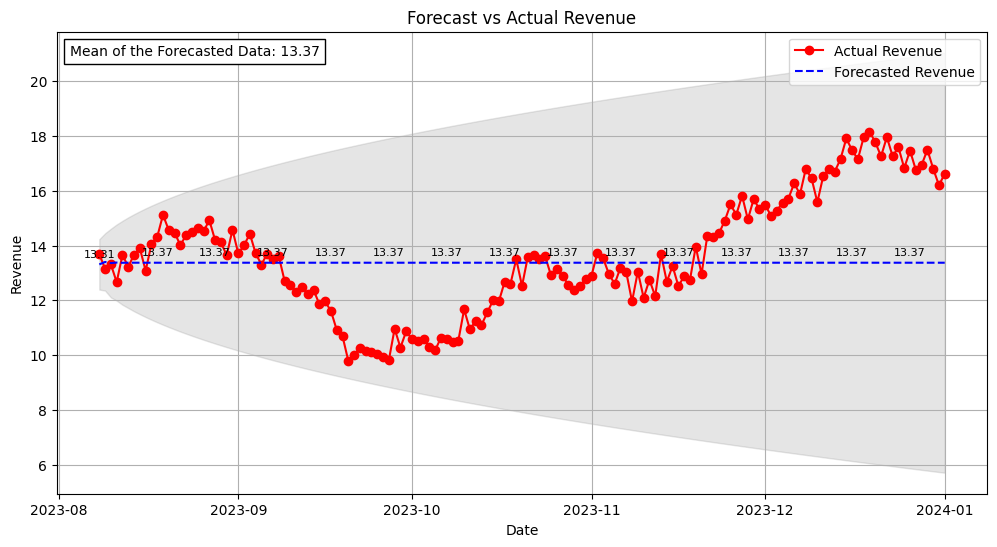

Mean of the Forecasted Data: 13.372004574619776


In [19]:

# Ensure model_fit is the fitted SARIMAX model object
forecast_results = sarimax_model_fit.get_forecast(steps=len(test))
forecast_df = forecast_results.summary_frame(alpha=0.05)

# Initialize the counter for annotations.
counter = 0  

# Plot the actual and forecasted revenue with confidence intervals.
plt.figure(figsize=(12, 6))

# Actual Revenue
plt.plot(df_test.index, df_test['Revenue'], label='Actual Revenue', color='red', marker='o')

# Forecasted Revenue
plt.plot(forecast_df.index, forecast_df['mean'], label='Forecasted Revenue', color='blue', linestyle='--')

# Confidence Intervals
plt.fill_between(forecast_df.index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='gray', alpha=0.2)

# Annotations for every 10th forecasted point
for idx, (date, row) in enumerate(forecast_df.iterrows()):
    if idx % 10 == 0:
        plt.annotate(f"{row['mean']:.2f}", 
                     (date, row['mean']),
                     textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

# Add a text box for mean of the forecasted data
mean_of_forecast = forecast_df['mean'].mean()
anchored_text = AnchoredText(f'Mean of the Forecasted Data: {mean_of_forecast:.2f}', loc='upper left')
plt.gca().add_artist(anchored_text)

plt.title('Forecast vs Actual Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()


# Printing the mean of the forecast
print("Mean of the Forecasted Data:", forecast_df['mean'].mean())



#### E3: Recommend a Course of Action Based on Your Results

Based on the analysis:

* Strategic Adjustments:
        If the forecast indicates a downward trend in revenue, consider strategies to boost customer engagement and acquisition. Initiatives could include marketing campaigns, loyalty programs, or diversification of service offerings.

* Operational Planning:
        Use the forecast to adjust supply chain operations, staffing, and inventory management to align with expected demand fluctuations shown in the forecast.

* Continual Monitoring and Model Refinement:
        Regularly update the model with new data to refine forecasts. Consider developing a dashboard for real-time monitoring of key performance indicators (KPIs) related to revenue.

* Risk Management:
        Develop contingency plans based on the prediction intervals to mitigate potential revenue shortfalls.

By following these recommendations, the organization can better align its strategies with expected financial outcomes and adjust more dynamically to external market conditions.

#### F: Reporting

I will be providing an Jupyter Notebook .ipynb file and a PDF of my report when submitting.

#### G: Code References

(Dr.Sewell powerpoint): https://westerngovernorsuniversity-my.sharepoint.com/:p:/g/personal/william_sewell_wgu_edu/EftnPPOZu8RNvZIbxqAUX0UBJkIAWl8QhKLQ63azgA8a-g?rtime=-ngVhKNc3Eg

(MachineLearningMastery.com, ADF): https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

(datacamp.com): https://campus.datacamp.com/courses/arima-models-in-python/the-best-of-the-best-models?ex=1&learningMode=course

(MachineLearningMastery.com, ARIMA): https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

(Time Series Forecasting With Python): https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/

#### H: Sources

(MachineLearningMastery.com, ADF): https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

(datacamp.com): https://campus.datacamp.com/courses/arima-models-in-python/the-best-of-the-best-models?ex=1&learningMode=course

(MachineLearningMastery.com, ARIMA): https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

(Time Series Forecasting With Python): https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/